In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Načtení dat
data = pd.read_csv("BTC-Daily.csv")  
#invertuji data aby nejstarsí ceny byli nahore, a nejnovejsí dole, dále prevádím na objekt pro LSTM - reshape
prices = data['close'][::-1].values.reshape(-1,1) 
prices = (np.log(prices))#logaritmus cen, kvuli volatylite

In [2]:
data

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646092800,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43185.48,4.900629e+01,2.116360e+06
1,1646006400,2022-02-28 00:00:00,BTC/USD,37717.10,44256.08,37468.99,43178.98,3.160618e+03,1.364723e+08
2,1645920000,2022-02-27 00:00:00,BTC/USD,39146.66,39886.92,37015.74,37712.68,1.701817e+03,6.418008e+07
3,1645833600,2022-02-26 00:00:00,BTC/USD,39242.64,40330.99,38600.00,39146.66,9.127241e+02,3.573010e+07
4,1645747200,2022-02-25 00:00:00,BTC/USD,38360.93,39727.97,38027.61,39231.64,2.202852e+03,8.642149e+07
...,...,...,...,...,...,...,...,...,...
2646,1417478400,2014-12-02 00:00:00,BTC/USD,378.39,382.86,375.23,379.25,2.593576e+06,6.832530e+03
2647,1417392000,2014-12-01 00:00:00,BTC/USD,376.40,382.31,373.03,378.39,2.520662e+06,6.660560e+03
2648,1417305600,2014-11-30 00:00:00,BTC/USD,376.57,381.99,373.32,373.34,1.145567e+06,3.046330e+03
2649,1417219200,2014-11-29 00:00:00,BTC/USD,376.42,386.60,372.25,376.72,2.746157e+06,7.245190e+03


In [21]:
prices.shape

(2651, 1)

In [4]:
# Normalizace dat
scaler = MinMaxScaler(feature_range=(0, 1))
prices = scaler.fit_transform(prices)


In [5]:
prices

array([[0.13968421],
       [0.13987791],
       [0.13838406],
       ...,
       [0.90336658],
       [0.92580216],
       [0.9258271 ]])

In [6]:
# Rozdělení dat na trénovací a testovací sady
train_size = int(len(prices) * 0.98)
train, test = prices[0:train_size, :], prices[train_size:len(prices), :]
test.shape

(54, 1)

In [7]:
# Funkce pro vytvoření datové sady pro LSTM
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [8]:
# Vytvoření trénovací a testovací sady
look_back = 20  # časový okamžik do minulosti
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


In [9]:
trainX

array([[0.13968421, 0.13987791, 0.13838406, ..., 0.12776429, 0.117941  ,
        0.11339932],
       [0.13987791, 0.13838406, 0.14061106, ..., 0.117941  , 0.11339932,
        0.10872438],
       [0.13838406, 0.14061106, 0.14098735, ..., 0.11339932, 0.10872438,
        0.11179134],
       ...,
       [0.94468754, 0.94634692, 0.94218004, ..., 0.93706275, 0.94257601,
        0.94108729],
       [0.94634692, 0.94218004, 0.93705038, ..., 0.94257601, 0.94108729,
        0.93786963],
       [0.94218004, 0.93705038, 0.93943966, ..., 0.94108729, 0.93786963,
        0.93564225]])

In [10]:
# Změna tvaru vstupních dat
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [11]:
trainX.shape

(2576, 1, 20)

# jednoducha RNN:

In [12]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Vytvoření a kompilace LSTM modelu
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Metal device set to: Apple M1 Max


2023-06-16 18:43:43.582597: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-16 18:43:43.582713: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 400       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 405
Trainable params: 405
Non-trainable params: 0
_________________________________________________________________


In [13]:

# Trénování modelu
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=1)

Epoch 1/10


2023-06-16 18:43:43.913149: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-16 18:43:44.394010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-16 18:43:44.456306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-16 18:43:44.527478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2576/2576 [==============================] - 15s 6ms/step - loss: 0.0038
Epoch 2/10
2576/2576 [==============================] - 14s 6ms/step - loss: 4.5854e-04
Epoch 3/10
2576/2576 [==============================] - 14s 6ms/step - loss: 2.8956e-04
Epoch 4/10
2576/2576 [==============================] - 14s 6ms/step - loss: 2.3096e-04
Epoch 5/10
2576/2576 [==============================] - 14s 6ms/step - loss: 1.8722e-04
Epoch 6/10
2576/2576 [==============================] - 15s 6ms/step - loss: 1.9873e-04
Epoch 7/10
2576/2576 [==============================] - 15s 6ms/step - loss: 1.6980e-04
Epoch 8/10
2576/2576 [==============================] - 14s 6ms/step - loss: 1.6025e-04
Epoch 9/10
2576/2576 [==============================] - 14s 6ms/step - loss: 1.5728e-04
Epoch 10/10
2576/2576 [==============================] - 14s 6ms/step - loss: 1.6110e-04


In [14]:
# Predikce cen
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Inverzní transformace predikcí a skutečných hodnot pro zpětné porovnání
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])


45/81 [===============>..............] - ETA: 0s

2023-06-16 18:46:09.454908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-16 18:46:09.483425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 71ms/step


In [15]:
# Inverzní transformace testovacích dat
testYr = scaler.inverse_transform([testY])[0]
testPredictr = scaler.inverse_transform(testPredict)
testPredictr= [i[0] for i in testPredictr]




In [16]:
# Výpočet MAPE v logaritmech
mape = np.mean(np.abs((testYr - testPredictr) / testYr)) * 100
print(f"MAPE: {mape}%")

MAPE: 0.6743046501471925%


In [17]:
# Výpočet MAPE v reálných hodnotách
mape = np.mean(np.abs((np.exp(testYr) - np.exp(testPredictr)) / np.exp(testYr))) * 100
print(f"MAPE: {mape}%")

MAPE: 7.483215733106885%


In [18]:
# pozor je to v procentech!!

In [19]:
import matplotlib.pyplot as plt

<AxesSubplot: >

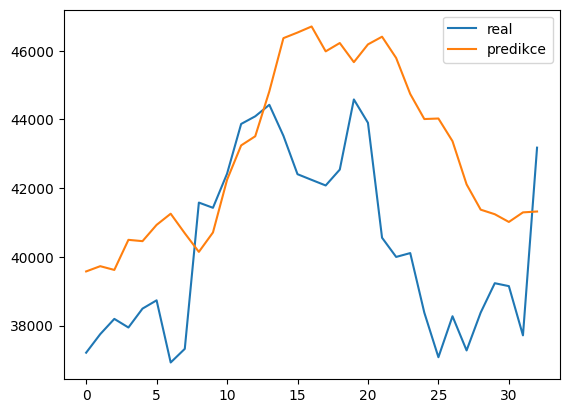

In [20]:
pd.DataFrame({"real": np.exp(testYr), "predikce": np.exp(testPredictr)}).plot()